In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F 
from torch import Tensor, nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor

In [2]:
def binarized(img):
    img = to_tensor(img)
    return (img > 0.5).type(torch.float32)

train_set = MNIST('datasets', train=True, download=True, transform=binarized)
len(train_set)

60000

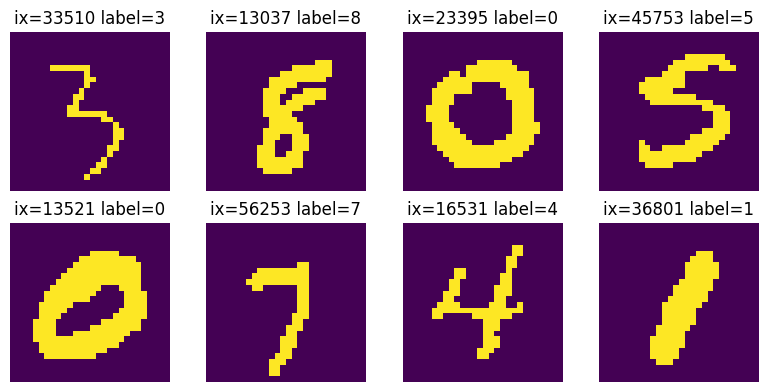

In [3]:
# See images in dataset
plt.figure(figsize=(8,4))
ixs = torch.randint(low=0, high=len(train_set), size=(8,)).tolist()
for i, ix in enumerate(ixs):
    img, label = train_set[ix]
    plt.subplot(2, 4, i+1)
    plt.imshow(torch.squeeze(img))
    plt.title(f'{ix=} {label=}')
    plt.axis('off')
plt.tight_layout()

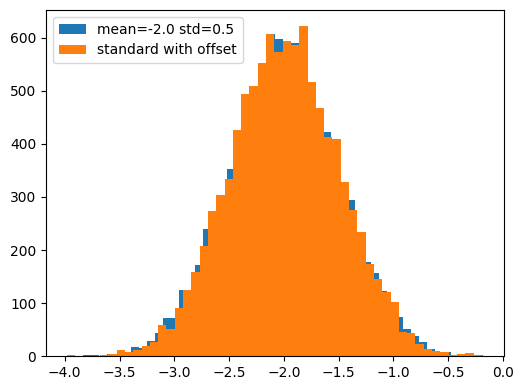

In [4]:
plt.figure(figsize=(10,4))

# Normal distribution with mean=-2.0 and std=0.5
plt.subplot(1, 2, 2)
plt.hist(torch.normal(mean=-2, std=0.5, size=(10000,)), bins=50, label='mean=-2.0 std=0.5')

# Standard normal distribution with offset
plt.hist(-2.0 - 0.5*torch.randn(size=(10000,)), bins=50, label='standard with offset')

plt.legend()
plt.tight_layout()

In [5]:
class VariationalAE(nn.Module):
    def __init__(self, latent_dims: int):
        super(VariationalAE, self).__init__()
        self.latent_dims = latent_dims
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=128),
            nn.Tanh(),
            # We need to generate mu and sigma so the ouput
            # size is the double of latent_dims
            nn.Linear(in_features=128, out_features=2*latent_dims)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dims, out_features=128),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=28*28),
            nn.Sigmoid(),
        )

    def encode(self, x: Tensor):
        encoding = torch.reshape(self.encoder(x), (-1, 2, self.latent_dims))
        mu, log_var = encoding[:, 0, :], encoding[:, 1, :]
        return mu, log_var

    def decode(self, z: Tensor):
        return self.decoder(z)

    def reparameterize(self, mu: Tensor, log_var: Tensor):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std*eps

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor, Tensor]:
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return (self.decode(z), mu, log_var)

net = VariationalAE(latent_dims=2)
net

VariationalAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [6]:
def loss_function(x: Tensor, x_hat: Tensor, mu: Tensor, log_var: Tensor):
    batch_size = x.size(0)

    x = x.reshape((batch_size, -1))
    x_hat = x_hat.reshape((batch_size, -1))

    recons_loss = F.binary_cross_entropy(x_hat, x, reduction='none').sum(dim=1).mean()
    KLd_loss = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean()
    return recons_loss, KLd_loss

In [7]:
# Train the network
epochs = 20
train_loader = DataLoader(train_set, batch_size=64, drop_last=True)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
recons_l, kld_l = [], []
for epoch in range(1, epochs+1):
    running_loss = 0
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()

        x = torch.flatten(images, start_dim=1)
        x_hat, mu, log_var = net(x)

        recons_loss, KLd_loss = loss_function(x, x_hat, mu, log_var)
        loss = recons_loss + KLd_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        recons_l.append(recons_loss.item())
        kld_l.append(KLd_loss.item())
    
    avg_loss = running_loss / (len(train_loader))
    print(f'Epoch {epoch} completed! Avg loss: {avg_loss}')

Epoch 1 completed! Avg loss: 193.5245685231342
Epoch 2 completed! Avg loss: 175.18489581162035
Epoch 3 completed! Avg loss: 169.90162026844004
Epoch 4 completed! Avg loss: 165.25630341064715
Epoch 5 completed! Avg loss: 161.6004777580595
Epoch 6 completed! Avg loss: 159.0007759020957
Epoch 7 completed! Avg loss: 157.04094058497864
Epoch 8 completed! Avg loss: 155.488762496248
Epoch 9 completed! Avg loss: 154.2022230866879
Epoch 10 completed! Avg loss: 153.10508249256375
Epoch 11 completed! Avg loss: 152.1697545005774
Epoch 12 completed! Avg loss: 151.33502654052214
Epoch 13 completed! Avg loss: 150.61508972591372
Epoch 14 completed! Avg loss: 149.93551551875845
Epoch 15 completed! Avg loss: 149.3827695978871
Epoch 16 completed! Avg loss: 148.8571759267703
Epoch 17 completed! Avg loss: 148.35257480747543
Epoch 18 completed! Avg loss: 147.93754840635057
Epoch 19 completed! Avg loss: 147.5494308390256
Epoch 20 completed! Avg loss: 147.20761571698915


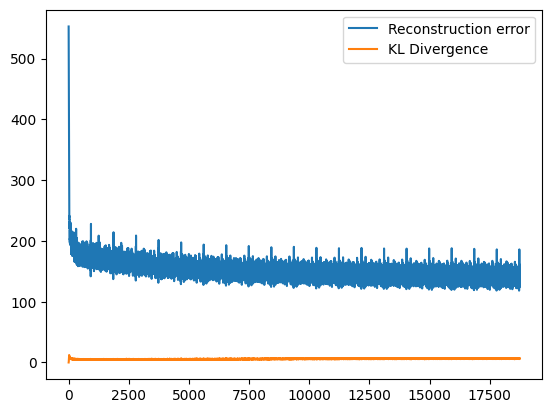

In [8]:
plt.plot(recons_l, label='Reconstruction error')
plt.plot(kld_l, label='KL Divergence')
plt.legend();

/var/folders/f0/bcsr84m12mg20tdcd868wcnm0000gn/T/ipykernel_12682/3673992218.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, i+1)


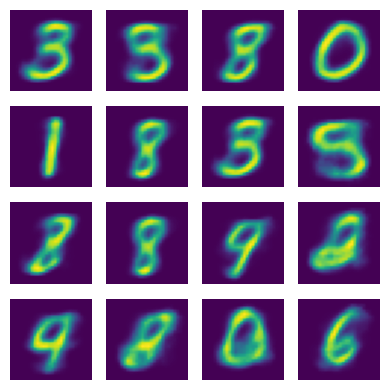

In [9]:
# Sample images from model
net.eval()
plt.figure(figsize=(4,4))
plt.title('Generated digits')
for i in range(16):
    with torch.no_grad():
        z = torch.randn((1, net.latent_dims))
        x, *_ = net.decode(z)
    plt.subplot(4, 4, i+1)
    plt.imshow(torch.reshape(x, (28, 28)))
    plt.axis('off')
plt.tight_layout()

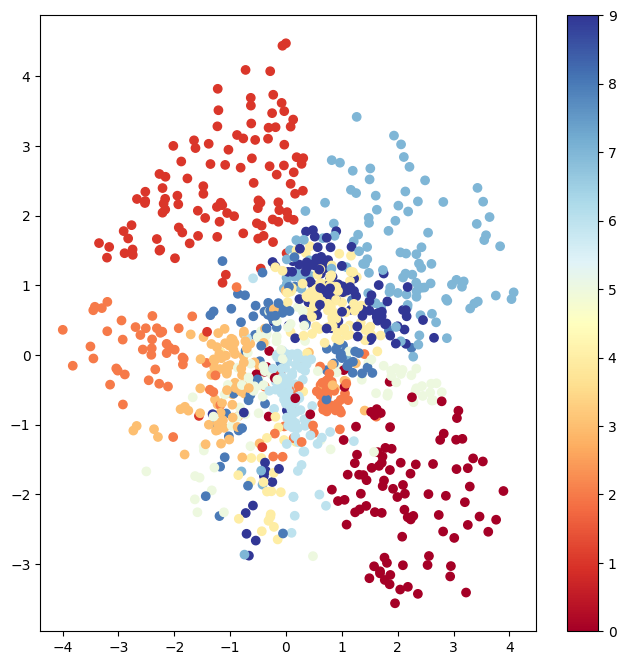

In [10]:
from matplotlib import colormaps

tsne_indexes = torch.randint(low=0, high=len(train_set), size=(1000,))

latent_vecs, labels = [], []
for ix in tsne_indexes:
    x, label = train_set[ix]
    with torch.no_grad():
        x = torch.flatten(x)
        mu, log_var = net.encode(x)
        z = net.reparameterize(mu, log_var)
    latent_vecs.append(z)
    labels.append(label)
latent_vecs = torch.cat(latent_vecs)

cm = colormaps['RdYlBu']
plt.figure(figsize=(8,8))
sc = plt.scatter(latent_vecs[:, 0], latent_vecs[:, 1], c=labels, cmap=cm)
plt.colorbar(sc)
plt.show()